## Comparing, Reconciling, and Combining COVID-19 Data Sources

### Summary

In this note we use `gs-quant` to compare COVID-19 data sources. To do this, we first retrieve COVID-19-related time 
series data and preprocess it, joining different sources together to analyze confirmed cases. 

The contents of this notebook are as follows:

- [1 - Getting Started](#1---Getting-Started)
- [2 - COVID-19 Data](#2---COVID-19-Data)
- [3 - Comparing Global Sources](#3---Comparing-Global-Sources)
- [4 - Comparing US Sources](#4---Comparing-US-Sources)
- [5 - Comparing subregions](#5---Comparing-subregions)
- [6 - Predicting Confirmed Cases and Fatalities](#6---Predicting-Confirmed-Cases-and-Fatalities)

### 1 - Getting Started

Start every session with authenticating with your unique client id and secret. For information on
how to get setup on GS Quant, see [Getting Started](/covid/guides/getting-started). Below produced
using gs-quant version 0.8.126

In [1]:
!pip install gs-quant
!pip install curveball

from IPython.display import clear_output
clear_output()


In [2]:
from gs_quant.session import GsSession, Environment

prod_session = GsSession.get(
    Environment.PROD,
    'client_id',
    'client_secret')

### 2 - COVID-19 Data

We'll start by defining a general function to load various datasets, which includes regional data,
since December 31 2019:

In [3]:
from gs_quant.data import Dataset
import datetime

def get_datasets(datasets, start=datetime.date(2020, 2, 1), end=datetime.datetime.today().date()):
    ds_dict = {}
    for dataset in datasets:
        try:
            with prod_session:
                df = Dataset(dataset).get_data(start=start,end=end)
            keys = [x for x in ['countryId', 'subdivisionId'] if x in df.columns] + ['date']
            val_map = {'newConfirmed': 'totalConfirmed', 'newFatalities': 'totalFatalities'}
            vals = [x for x in list(val_map.keys()) if x in df.columns]

            df_t = df.groupby(keys).sum().groupby(level=0).cumsum().reset_index()[keys + vals].rename(columns=val_map)
            ds_dict[dataset] = df.reset_index().merge(df_t, on=keys, suffixes=('', '_y')).set_index('date')
            print(f'Fetched {dataset}')

        except Exception as err:
            print(f'Failed to obtain {dataset} with {getattr(err,"message",repr(err))}')
    return ds_dict

We create a list of some of the available datasets, and fetch all of them, so that we can compare them.

In [4]:
country_datasets = [
    'COVID19_COUNTRY_DAILY_ECDC', 
    'COVID19_US_DAILY_CDC',
    'COVID19_COUNTRY_DAILY_WIKI'
]
df = get_datasets(country_datasets)

Fetched COVID19_COUNTRY_DAILY_ECDC
Fetched COVID19_US_DAILY_CDC
Fetched COVID19_COUNTRY_DAILY_WIKI


Next we look at the date ranges of each dataset to determine how much history they have, and ensure they are 
up-to-date:

In [5]:
for name, ds in df.items():
    print('{:<30}  {}  {}'.format(name, ds.index[0].date(), ds.index[-1].date())) 

COVID19_COUNTRY_DAILY_ECDC      2020-02-01  2020-09-20
COVID19_US_DAILY_CDC            2020-02-01  2020-08-26
COVID19_COUNTRY_DAILY_WIKI      2020-04-06  2020-09-20


### 3 - Comparing Global Sources

Below is a general function to compare the time series of certain columns across datasets:

In [6]:
import re
from typing import Union

def compare_time_series(df, datasets, columns: Union[str, list], grouping: str = 'countryId', suffix_identifier: float = 1):
    columns = [columns] if isinstance(columns, str) else columns
    suffixes = list(map(lambda ds_name: '_' + re.findall('\_([A-Z]+)', ds_name)[-suffix_identifier], datasets))
    df_combo = None

    for ds_name in datasets:
        ds = df[ds_name]
        df_combo = ds if df_combo is None else df_combo
        df_suffixes = ('', '_' + re.findall('\_([A-Z]+)', ds_name)[-suffix_identifier])
        df_combo = df_combo.merge(ds, on=['date', grouping], suffixes=df_suffixes)

    return df_combo[[grouping] + [column + suffix for suffix in suffixes for column in columns]]

For example, if we want to compare the time series for total confirmed cases across the ECDC and Wikipedia 
datasets globally, we can do the following:

In [7]:
datasets = ['COVID19_COUNTRY_DAILY_ECDC', 'COVID19_COUNTRY_DAILY_WIKI'] 
df_to_compare = compare_time_series(df, datasets, columns='totalConfirmed')

df_to_compare.describe().style.background_gradient(cmap='Blues',axis=1).format('{:,.2f}')

,totalConfirmed_ECDC,totalConfirmed_WIKI
count,"20,268.00","20,268.00"
mean,"31,732.88","41,257.73"
std,"163,939.10","263,185.74"
min,1.00,0.00
25%,156.00,174.00
50%,"1,239.00","1,422.00"
75%,"9,686.00","11,225.50"
max,"3,439,892.00","6,863,854.00"


This shows statistical properties for each dataset for all common countries and dates. As we can see, there's some 
variation in the data sources. Let's dig in a little further and plot the relationship between the WHO and ECDC for 
a number of countries: 

As we can see, there is some dispersion between sources for certain countries. For information on the various ISO
country codes, see [this guide](https://developer.gs.com/docs/covid/guides/standards/iso-countries/).

### 4 - Comparing US Sources

Now let's take a closer look at the US data, adding in the CDC dataset:

In [8]:
datasets = ['COVID19_US_DAILY_CDC', 'COVID19_COUNTRY_DAILY_ECDC', 'COVID19_COUNTRY_DAILY_WIKI'] 
df_to_compare = compare_time_series(df, datasets, columns='totalConfirmed')

df_to_compare.describe().style.background_gradient(cmap='Blues',axis=1).format('{:,.2f}')

,totalConfirmed_CDC,totalConfirmed_ECDC,totalConfirmed_WIKI
count,92.00,92.00,92.00
mean,"1,625,219.67","1,584,656.62","1,658,904.90"
std,"717,340.76","695,206.66","729,021.16"
min,"374,329.00","337,629.00","367,461.00"
25%,"1,054,499.25","1,033,071.50","1,084,555.25"
50%,"1,629,785.00","1,593,929.00","1,656,906.00"
75%,"2,111,444.00","2,080,935.25","2,160,977.50"
max,"3,106,931.00","3,002,723.00","3,165,058.00"


As of 21 of May 2020, CDC had the most confirmed cases, followed by Wikipedia, and then ECDC and WHO. This is not 
overly surprising given the information collection and validation flows. Now let's examine the last few points:

Now let's compare all the series side by side:

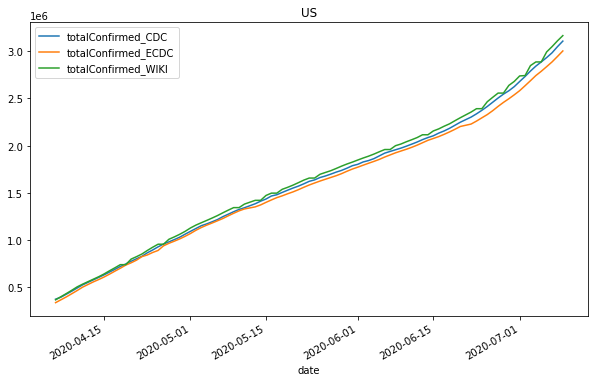

In [9]:
df_to_compare.plot(figsize=(10, 6), title='US');

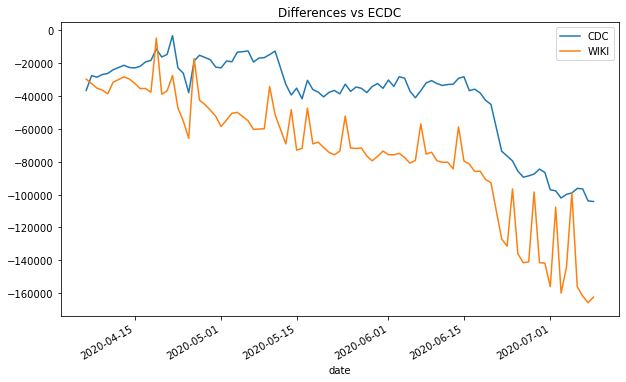

In [10]:
import matplotlib.pyplot as plt

(df_to_compare['totalConfirmed_ECDC']-df_to_compare['totalConfirmed_CDC']).plot(figsize=(10, 6), title='Differences vs ECDC', 
                                                                                label='CDC')
(df_to_compare['totalConfirmed_ECDC']-df_to_compare['totalConfirmed_WIKI']).plot(label='WIKI');

plt.legend();

This chart illustrates how the CDC and Wiki map cases versus the ECDC. At the start of the epidemic these sources were
much closer, and diverged over time, with ECDC leading in reporting for the US versus the CDC and Wiki. 

### 5 - Comparing subregions

Finally, we illustrate how to compare datasets for specific countries (in this case, Italy) at different level of granularity (region, province, etc.) and how to ccombine epidemic data with mobility data from Google.

As before, we fetch data for Italy, at three levels of granularity.

In [11]:
datasets = ['COVID19_ITALY_DAILY_DPC', 'COVID19_REGION_DAILY_DPC', 'COVID19_PROVINCE_DAILY_DPC'] 
df = get_datasets(datasets, start=datetime.date(2020,6,1), end=datetime.date(2020,6,30))

Fetched COVID19_ITALY_DAILY_DPC
Fetched COVID19_REGION_DAILY_DPC
Fetched COVID19_PROVINCE_DAILY_DPC


In [12]:
df_to_compare = compare_time_series(df, datasets, columns='totalConfirmed', suffix_identifier=3)

df_to_compare.describe().style.background_gradient(cmap='Blues',axis=1).format('{:,.2f}')

,totalConfirmed_ITALY,totalConfirmed_REGION,totalConfirmed_PROVINCE
count,"83,895.00","83,895.00","83,895.00"
mean,"237,268.59","11,298.50","1,800.17"
std,"2,251.14","19,882.02","3,198.93"
min,"233,197.00",399.00,0.00
25%,"235,278.00","1,432.00",214.00
50%,"237,500.00","4,448.00",662.00
75%,"239,410.00","9,940.00","2,168.00"
max,"240,578.00","93,901.00","24,379.00"


We write a function to compare the data across different geographic subdivisions.

In [13]:
from functools import reduce
import pandas as pd

def compare_totals_across_breakdowns(df, data1, data2, column_to_check):
    
    # pick the common indices between the data being compared
    common_idx_province = reduce(lambda x, y:  x & y, 
                            df[data1[0]].groupby(data1[1]).apply(lambda x: x.index).tolist())
    common_idx_region = reduce(lambda x, y:  x & y, 
                            df[data2[0]].groupby(data2[1]).apply(lambda x: x.index).tolist())
    idx = common_idx_province & common_idx_region
    
    # calculate the difference, and rename column
    diff = df[data1[0]].groupby(data1[1]).apply(lambda x : x.loc[idx][column_to_check]).T.apply(sum,axis=1) -\
           df[data2[0]].groupby(data2[1]).apply(lambda x : x.loc[idx][column_to_check]).T.apply(sum,axis=1)
    diff = pd.DataFrame(diff).rename(columns={0:f'{data1[0]}-{data2[0]}'})
    return diff

diff1 = compare_totals_across_breakdowns(df, ('COVID19_ITALY_DAILY_DPC','countryId'),
                                         ('COVID19_REGION_DAILY_DPC','subdivisionId'),'totalConfirmed')
diff2 = compare_totals_across_breakdowns(df, ('COVID19_REGION_DAILY_DPC','subdivisionId'),
                                        ('COVID19_PROVINCE_DAILY_DPC','administrativeRegion'),'totalConfirmed')

We plot the discrepancies below...

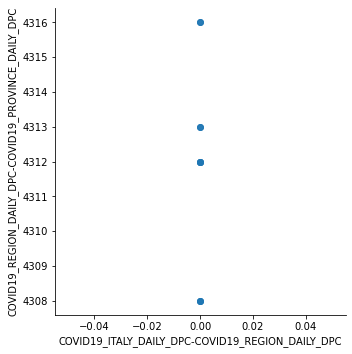

In [14]:
import seaborn as sns

to_plot = diff1.join(diff2)

sns.lmplot(x="COVID19_ITALY_DAILY_DPC-COVID19_REGION_DAILY_DPC", y="COVID19_REGION_DAILY_DPC-COVID19_PROVINCE_DAILY_DPC",
          data=to_plot);

... and interestingly, this indicates there is no discrepancy at all when we compare country-level aggregate data with region-level aggregate data, but we do see discrepancies when we compare province-level with region-level data.

### 6 - Predicting Confirmed Cases and Fatalities

We now use the confirmed case and fatalities counts in different countries to project numbers in future, using a few growth models. Growth models take a form similar to a [logistic function](https://en.wikipedia.org/wiki/Logistic_function), and generally fit best when there is a single wave of COVID-19 infections. When there are multiple waves, fitting using growth models isn't fully appropriate.

In [15]:
import curveball
import numpy as np
from matplotlib import dates as mdates
from matplotlib import ticker


def plot_predictions(
    countryId, country, ax,
    plotComparisons=False,
    start=datetime.date(2020,2,1),
    end=datetime.datetime.today().date(),
    field="totalConfirmed",
    fontsize=12):
        
    with prod_session:
        covid = Dataset('COVID19_COUNTRY_DAILY_WHO')
        df = covid.get_data(countryId=countryId, start=start, end=end)
    
    # Pre-process inputs to run the model
    daily = df[field]
    daily = daily[daily.gt(1)].dropna()
    df = daily.to_frame().reset_index()
    
    df = df.assign(Time=df.index, OD=df[field])
    df_model = df[["Time", "OD"]]
    
    if(plotComparisons):
        models, fig, ax2 = curveball.models.fit_model(df_model, PLOT=True)
    else:
        models = curveball.models.fit_model(df_model, PLOT=False, PRINT=False)
        
    model = models[0]
    
    # predicting using the model with best fit
    xwide = np.linspace(0, len(df_model)+14, len(df_model)+15)
    df_results = pd.DataFrame(data=model.model.eval(t=xwide, params=model.result.params), columns=["predicted"])
    
    # The results are for t=1...n, joining with input dataset to get the dates
    df_output = df_results.join(df)
    
    # For dates in future, add dates, since they were missing in the input dataset
    for i in range(1, len(df_output)):
        if(i>=len(df_model)):
            df_output.loc[i, 'date'] = df_output.loc[i-1, 'date'] + datetime.timedelta(days=1)
    
    df_output = df_output.set_index("date")
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.yaxis.tick_right()
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.tick_params(labelsize=fontsize)
    
    # Plotting
    ax.bar(df_output.index, df_output[field], label=field, color="#f6d743")
    ax.plot(df_output["predicted"], label="Predicted", color="#06623b")
    ax.set_title(country, fontsize=fontsize)
    ax.text(0.9, 0.1, model.model._name, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes, fontsize=fontsize)
    

We use [Curveball](https://curveball.yoavram.com/) python library to fit the available data using 6 available growth functions - Richards Growth, Logistic, Baranyi Roberts, Richards Lag 1, Logistic Lag 1, Logistic Lag 2. Take a look at [Curveball growth models documentation](https://curveball.yoavram.com/models) for details on these models.

The model with best fit is chosen for predictions. Key model stats are also printed.

[[Model]]
    Model(Richards)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 476
    # data points      = 208
    # variables        = 4
    chi-square         = 7.3361e+10
    reduced chi-square = 3.5961e+08
    Akaike info crit   = 4101.67299
    Bayesian info crit = 4115.02314
[[Variables]]
    y0:  246.218830 +/- 85.0169860 (34.53%) (init = 5)
    K:   6523786.54 +/- 79687.8722 (1.22%) (init = 4495183)
    r:   0.18580583 +/- 0.03230445 (17.39%) (init = 0.03802851)
    nu:  0.10000000 +/- 0.03928316 (39.28%) (init = 1)


Text(0.5, 0.98, 'Total Confirmed Predictions for Brazil')

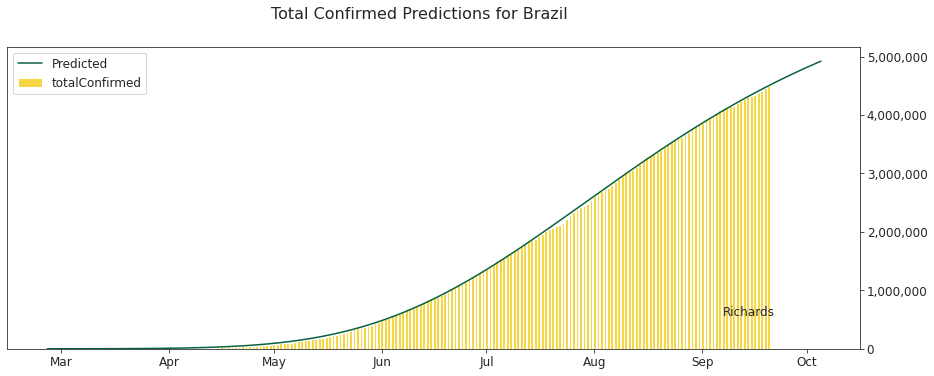

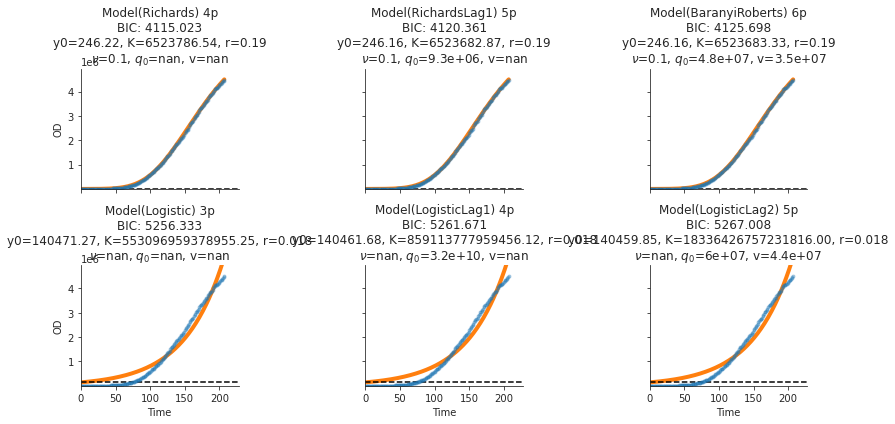

In [16]:
fig, ax = plt.subplots(figsize=(1100/72, 400/72))
plot_predictions("BR", "", ax, plotComparisons=True, field="totalConfirmed")
ax.legend(fontsize=12)
fig.suptitle('Total Confirmed Predictions for Brazil', fontsize=16)

#### Predicting Total Confirmed for few countries with a single wave of COVID-19

In [17]:
countries=pd.DataFrame(np.array([
    ["BR", "Brazil"],
    ["IN", "India"],
    ["ZA", "South Africa"],
    ["CO", "Colombia"],
    ["MX", "Mexico"],
    ["AR", "Argentina"],
]), columns=['countryId', 'country'])
countries = countries.sort_values(by=["country"]).reset_index()

In [18]:
def compare_countries(countries, ncols=2, field="totalConfirmed", start=datetime.date(2020,2,1)):
    nrows = int(np.ceil(len(countries) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*5))

    for i in range(0, len(countries)):
        country, countryId = [countries.loc[i, 'country'], countries.loc[i, 'countryId']]
        clear_output(wait=True)
        print(f'[{i+1}/{len(countries)}] Processing {country}')
        plot_predictions(countryId, country, axes.flat[i], field=field, start=start, fontsize=14)
        
    clear_output()

    fig.tight_layout()
    fig.set_facecolor('w')

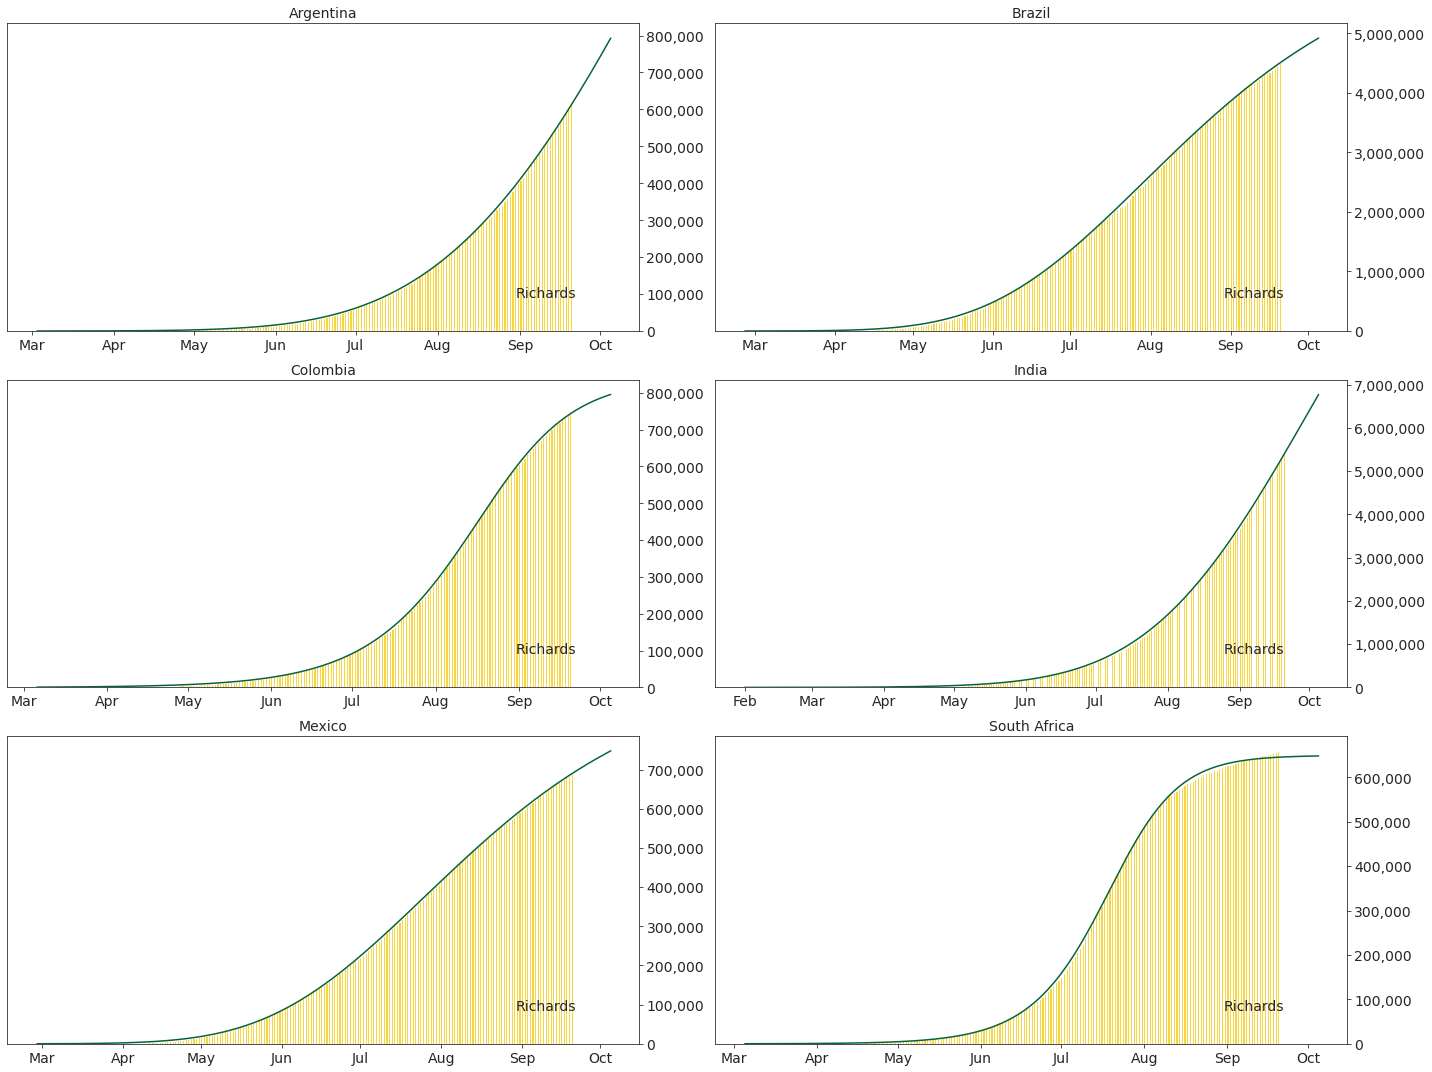

In [19]:
compare_countries(countries, field="totalConfirmed")

#### Predicting Total Fatalities for few countries with a single wave of COVID-19

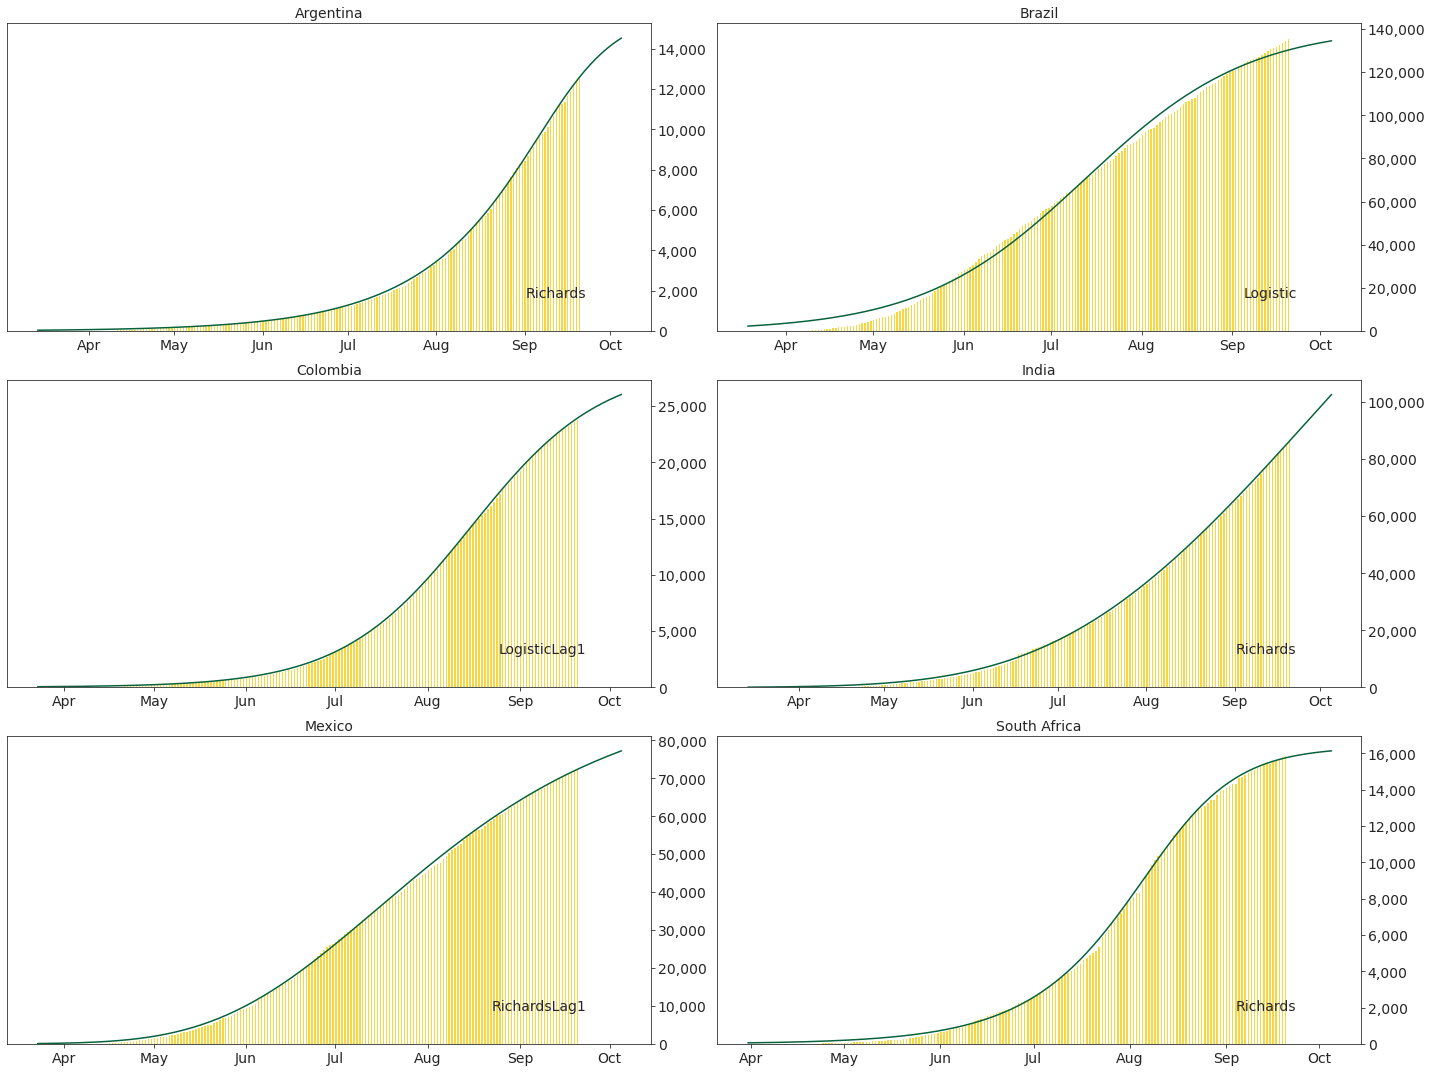

In [20]:
compare_countries(countries, field="totalFatalities")

#### Predicting Total Confirmed for few countries with a multiple waves of COVID-19

As you can see, the fits are poor when there are multiple waves of COVID-19, so it isn't recommened to use this framework for countries where there have been multiple waves of COVID-19.

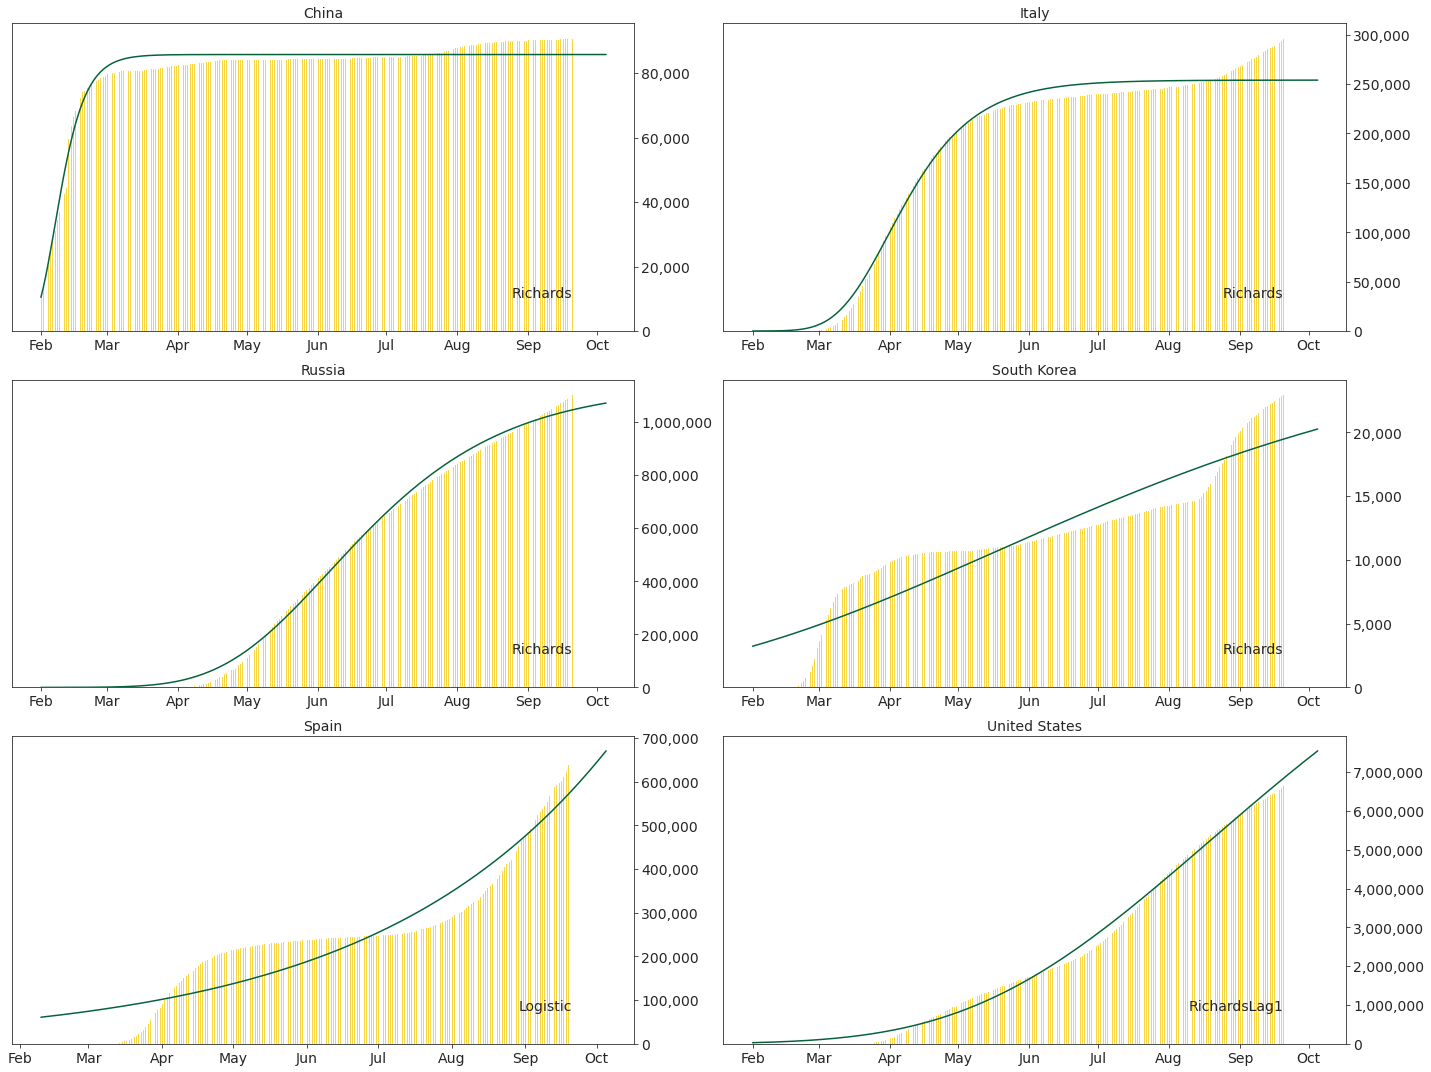

In [21]:
countries=pd.DataFrame(np.array([
    ["US", "United States"],
    ["ES", "Spain"],
    ["IT", "Italy"],
    ["CN", "China"],
    ["KR", "South Korea"],
    ["RU", "Russia"],
]), columns=['countryId', 'country'])
countries = countries.sort_values(by=["country"]).reset_index()

compare_countries(countries, field="totalConfirmed")

Please reach out to `covid-data@gs.com` with any questions.

### Disclaimer
This website may contain links to websites and the content of third parties ("Third Party Content"). We do not monitor, 
review or update, and do not have any control over, any Third Party Content or third party websites. We make no 
representation, warranty or guarantee as to the accuracy, completeness, timeliness or reliability of any 
Third Party Content and are not responsible for any loss or damage of any sort resulting from the use of, or for any 
failure of, products or services provided at or from a third party resource. If you use these links and the 
Third Party Content, you acknowledge that you are doing so entirely at your own risk.